# Deregularization w/ Hard Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


**deregularization**
reduce $\lambda$ wrt the optimal value in an estimator on the same dataset; and make it fixed, instead of having the GPR optimize it. The idea is to reduce bias in a single estimator and average them out to surpress the increased variance. 

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    ## colab
    import sys,os
    !git clone -b mpi https://github.com/tlpss/ML-Project2.git
    sys.path.append(os.path.abspath(os.path.join('./ML-Project2')))

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X
from aggregating.models import SimpleBagger

## Parameter Configuration

In [3]:
np.random.seed(2020)

In [4]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [5]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [6]:
#kernel FIX LAMBDA
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0]+lambda_range[1])/2,noise_level_bounds = lambda_range)


In [7]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [8]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0793534441124991

In [9]:
X_test.shape

(50000, 1, 2)

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [13]:
#reference error: no ensemble; no fixing lambda

hyperparams= {'M':1, 'train_size_alpha':1.0}
model = GaussianProcessRegressor(kernel)
reference_error = evaluate_model(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],5,N_test,MaxCallStochasticModel)
reference_error_mean = sum(reference_error)/len(reference_error)
print(reference_error_mean)

 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 35060
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.11480572178179495
{'M': 1, 'train_size_alpha': 1.0} , 1 -> 0.17124000725126198
{'M': 1, 'train_size_alpha': 1.0} , 2 -> 0.14258894235284092
{'M': 1, 'train_size_alpha': 1.0} , 3 -> 0.12155161802293622
{'M': 1, 'train_size_alpha': 1.0} , 4 -> 0.14485188343340394
{'M': 1, 'train_size_alpha': 1.0} -> [0.11480572178179495, 0.17124000725126198, 0.14258894235284092, 0.12155161802293622, 0.14485188343340394]
0.1390076345684476


In [14]:
#get "optimal" lambda
#kernel_fixed = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) + WhiteKernel(noise_level= 1e-5 , noise_level_bounds='fixed')
model = GaussianProcessRegressor(kernel)  
indices = np.random.choice(N_train,int(N_train*0.4),replace=True)
model.fit(flatten_X(X_train[indices]),y_train[indices])
print(model.kernel_.get_params())

{'k1': RBF(length_scale=0.776), 'k2': WhiteKernel(noise_level=5e-06), 'k1__length_scale': 0.7761505257063328, 'k1__length_scale_bounds': array([ 0.77615053, 77.61505257]), 'k2__noise_level': 4.999999999999999e-06, 'k2__noise_level_bounds': (5e-06, 5.0)}


In [11]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

lambda_ = 1e-7

kernel_fixed = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= lambda_ , noise_level_bounds="fixed")
# GRIDSEARCH PARAMS
model = SimpleBagger(0,0,GaussianProcessRegressor(kernel_fixed,copy_X_train=False)) ## USE THE FIXED LAMBDA KERNEL
trials = 1
M_grid = [1,3,5,7,9]
alpha_grid = [0.2,0.3,0.4,0.5]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(5) #hyperthreading 
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel,V_0,None,[2020,2021,2022]),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



 {'M': 1, 'train_size_alpha': 0.2} -> thread id = 35904
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.3} -> thread id = 18296
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.4} -> thread id = 31720
fit
(5000, 2)
 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 34948
fit
(5000, 2)
 {'M': 3, 'train_size_alpha': 0.2} -> thread id = 5696
fit
(5000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 1, 'train_size_alpha': 0.2} , 0 -> 0.8492482609074906
{'M': 1, 'train_size_alpha': 0.2} -> [0.8492482609074906]
 {'M': 3, 'train_size_alpha': 0.3} -> thread id = 35904logger {'M': 1, 'train_size_alpha': 0.2}, -> [0.8492482609074906]
fit
(5000, 2)



c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 1, 'train_size_alpha': 0.3} , 0 -> 0.7165502706796718
{'M': 1, 'train_size_alpha': 0.3} -> [0.7165502706796718]
 {'M': 3, 'train_size_alpha': 0.4} -> thread id = 18296logger {'M': 1, 'train_size_alpha': 0.3}, -> [0.7165502706796718]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


{'M': 1, 'train_size_alpha': 0.4} , 0 -> 0.4259946639539798
{'M': 1, 'train_size_alpha': 0.4} -> [0.4259946639539798]
 {'M': 3, 'train_size_alpha': 0.5} -> thread id = 31720logger {'M': 1, 'train_size_alpha': 0.4}, -> [0.4259946639539798]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


{'M': 1, 'train_size_alpha': 0.5} , 0 -> 0.49645701214068017
{'M': 1, 'train_size_alpha': 0.5} -> [0.49645701214068017]
 {'M': 5, 'train_size_alpha': 0.2} -> thread id = 34948
fit
(5000, 2)
logger {'M': 1, 'train_size_alpha': 0.5}, -> [0.49645701214068017]
predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


{'M': 3, 'train_size_alpha': 0.2} , 0 -> 0.47679993772137447
{'M': 3, 'train_size_alpha': 0.2} -> [0.47679993772137447]
 {'M': 5, 'train_size_alpha': 0.3} -> thread id = 5696logger {'M': 3, 'train_size_alpha': 0.2}, -> [0.47679993772137447]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


predict
(50000, 2)
predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 3, 'train_size_alpha': 0.3} , 0 -> 0.38506444585227884
{'M': 3, 'train_size_alpha': 0.3} -> [0.38506444585227884]
 {'M': 5, 'train_size_alpha': 0.4} -> thread id = 35904
fitlogger {'M': 3, 'train_size_alpha': 0.3}, -> [0.38506444585227884]
(5000, 2)



c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 3, 'train_size_alpha': 0.4} , 0 -> 0.3557596050910259
{'M': 3, 'train_size_alpha': 0.4} -> [0.3557596050910259]
 {'M': 5, 'train_size_alpha': 0.5} -> thread id = 18296logger {'M': 3, 'train_size_alpha': 0.4}, -> [0.3557596050910259]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 5, 'train_size_alpha': 0.2} , 0 -> 0.5795751085587987
{'M': 5, 'train_size_alpha': 0.2} -> [0.5795751085587987]
 {'M': 7, 'train_size_alpha': 0.2} -> thread id = 34948logger {'M': 5, 'train_size_alpha': 0.2}, -> [0.5795751085587987]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 3, 'train_size_alpha': 0.5} , 0 -> 0.44518501053527215
{'M': 3, 'train_size_alpha': 0.5} -> [0.44518501053527215]
 {'M': 7, 'train_size_alpha': 0.3} -> thread id = 31720logger {'M': 3, 'train_size_alpha': 0.5}, -> [0.44518501053527215]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 5, 'train_size_alpha': 0.3} , 0 -> 0.5166286190957879
{'M': 5, 'train_size_alpha': 0.3} -> [0.5166286190957879]
 {'M': 7, 'train_size_alpha': 0.4} -> thread id = 5696logger {'M': 5, 'train_size_alpha': 0.3}, -> [0.5166286190957879]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

predict
(50000, 2)
predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 5, 'train_size_alpha': 0.4} , 0 -> 0.34627169638815836
{'M': 5, 'train_size_alpha': 0.4} -> [0.34627169638815836]
 {'M': 7, 'train_size_alpha': 0.5} -> thread id = 35904logger {'M': 5, 'train_size_alpha': 0.4}, -> [0.34627169638815836]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


{'M': 7, 'train_size_alpha': 0.2} , 0 -> 0.42061805942501684
{'M': 7, 'train_size_alpha': 0.2} -> [0.42061805942501684]
 {'M': 9, 'train_size_alpha': 0.2} -> thread id = 34948logger {'M': 7, 'train_size_alpha': 0.2}, -> [0.42061805942501684]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 7, 'train_size_alpha': 0.3} , 0 -> 0.4340857372759548
{'M': 7, 'train_size_alpha': 0.3} -> [0.4340857372759548]
 {'M': 9, 'train_size_alpha': 0.3} -> thread id = 31720logger {'M': 7, 'train_size_alpha': 0.3}, -> [0.4340857372759548]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


{'M': 5, 'train_size_alpha': 0.5} , 0 -> 0.4288766817166879
{'M': 5, 'train_size_alpha': 0.5} -> [0.4288766817166879]
 {'M': 9, 'train_size_alpha': 0.4} -> thread id = 18296logger {'M': 5, 'train_size_alpha': 0.5}, -> [0.4288766817166879]

fit
(5000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 7, 'train_size_alpha': 0.4} , 0 -> 0.28631779233750604
{'M': 7, 'train_size_alpha': 0.4} -> [0.28631779233750604]
 {'M': 9, 'train_size_alpha': 0.5} -> thread id = 5696
fit
(5000, 2)
logger {'M': 7, 'train_size_alpha': 0.4}, -> [0.28631779233750604]


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 9, 'train_size_alpha': 0.2} , 0 -> 0.45979637635280507
{'M': 9, 'train_size_alpha': 0.2} -> [0.45979637635280507]
logger {'M': 9, 'train_size_alpha': 0.2}, -> [0.45979637635280507]


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

predict
(50000, 2)


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 7, 'train_size_alpha': 0.5} , 0 -> 0.2523534295870034
{'M': 7, 'train_size_alpha': 0.5} -> [0.2523534295870034]
logger {'M': 7, 'train_size_alpha': 0.5}, -> [0.2523534295870034]


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


{'M': 9, 'train_size_alpha': 0.3} , 0 -> 0.3767312683653639
{'M': 9, 'train_size_alpha': 0.3} -> [0.3767312683653639]
logger {'M': 9, 'train_size_alpha': 0.3}, -> [0.3767312683653639]


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 9, 'train_size_alpha': 0.4} , 0 -> 0.2750310865006354
{'M': 9, 'train_size_alpha': 0.4} -> [0.2750310865006354]
logger {'M': 9, 'train_size_alpha': 0.4}, -> [0.2750310865006354]


c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\local\programs\python\python37\lib\site-packages\sklearn\gaussian_process\_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
c:\users\thoma\appdata\l

{'M': 9, 'train_size_alpha': 0.5} , 0 -> 0.2794378008897554
{'M': 9, 'train_size_alpha': 0.5} -> [0.2794378008897554]
logger {'M': 9, 'train_size_alpha': 0.5}, -> [0.2794378008897554]


In [12]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.2, [0.8492482609074906]]
[1, 0.3, [0.7165502706796718]]
[1, 0.4, [0.4259946639539798]]
[1, 0.5, [0.49645701214068017]]
[3, 0.2, [0.47679993772137447]]
[3, 0.3, [0.38506444585227884]]
[3, 0.4, [0.3557596050910259]]
[5, 0.2, [0.5795751085587987]]
[3, 0.5, [0.44518501053527215]]
[5, 0.3, [0.5166286190957879]]
[5, 0.4, [0.34627169638815836]]
[7, 0.2, [0.42061805942501684]]
[7, 0.3, [0.4340857372759548]]
[5, 0.5, [0.4288766817166879]]
[7, 0.4, [0.28631779233750604]]
[9, 0.2, [0.45979637635280507]]
[7, 0.5, [0.2523534295870034]]
[9, 0.3, [0.3767312683653639]]
[9, 0.4, [0.2750310865006354]]
[9, 0.5, [0.2794378008897554]]
(5, 4, 1)
[[[0.84924826]
  [0.71655027]
  [0.42599466]
  [0.49645701]]

 [[0.47679994]
  [0.38506445]
  [0.35575961]
  [0.44518501]]

 [[0.57957511]
  [0.51662862]
  [0.3462717 ]
  [0.42887668]]

 [[0.42061806]
  [0.43408574]
  [0.28631779]
  [0.25235343]]

 [[0.45979638]
  [0.37673127]
  [0.27503109]
  [0.2794378 ]]]


In [13]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(5, 4)

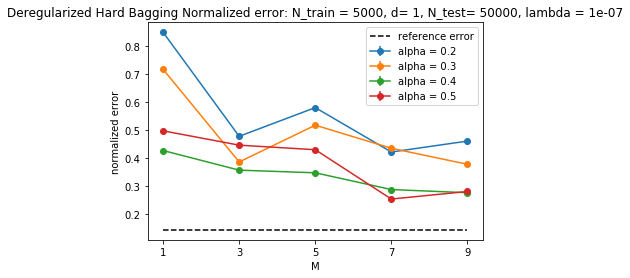

In [14]:
plt.hlines(0.1419,xmin=M_grid[0],xmax=M_grid[-1],linestyles='dashed',label="reference error")
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Deregularized Hard Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}, lambda = {lambda_}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend(loc='upper right')
plt.savefig("dereg_hard_bagging.png")
plt.show()


## Store results

In [19]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [20]:
import json
import datetime
with open(f'dereg_soft_bagging_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)